### Data Preparation

**Import Library**

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
tf.random.set_seed(42)
sns.set_theme(style="whitegrid")
import matplotlib.dates as mdates

# !pip install keras-tuner
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import ModelCheckpoint

**Read the files**

In [9]:
set1 = pd.read_csv('../Data/SET_main.csv')

# This file is consist of data that have Nan values
set2 = pd.read_csv('../Data/SET_residual.csv')

sp500 = pd.read_csv('../Data/sp500_main.csv')

In [10]:
set1 = set1.set_index('Date')
set1

,ADVANC.BK,AOT.BK,BBL.BK,BDMS.BK,BH.BK,CPALL.BK,CPF.BK,CPN.BK,DELTA.BK,HMPRO.BK,INTUCH.BK,IVL.BK,KBANK.BK,KTB.BK,MINT.BK,PTT.BK,PTTEP.BK,SCC.BK,TRUE.BK,TTB.BK
Date,,,,,,,,,,,,,,,,,,,,
2014-01-02,115.707695,13.004045,112.167664,8.865041,68.680244,33.136929,22.704105,31.580967,4.015339,4.772995,36.063667,14.913610,107.741776,9.801532,15.467829,16.889353,93.353264,263.643036,5.398062,1.198794
2014-01-03,121.276527,12.870900,113.856918,8.824374,69.914032,33.136929,22.704105,31.159885,3.846470,4.633434,36.908916,14.837523,111.814484,9.864767,15.223605,16.519508,92.148727,262.951050,5.318678,1.186436
2014-01-06,124.370323,12.648986,117.235466,9.678345,69.091530,33.344040,21.773605,31.580967,3.696364,4.605521,37.190655,14.913610,116.257446,9.991237,16.363337,16.272951,89.137291,266.411011,5.477446,1.217332
2014-01-07,129.939133,13.447869,120.276161,9.556350,68.474625,33.965351,22.704105,32.844200,3.771417,4.717172,38.176777,15.446239,119.959915,10.244180,17.096024,17.320827,92.449844,269.178833,5.636212,1.229691
2014-01-08,127.464096,12.870900,119.938301,9.312360,67.446480,33.551147,22.145803,32.633663,3.790180,4.633434,38.035904,15.978869,119.959915,9.991237,16.526155,17.567392,94.256668,271.254791,5.398062,1.248229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-03,296.000000,61.209999,150.500000,26.000000,212.000000,63.750000,24.200001,60.500000,151.000000,9.900000,102.500000,24.600000,153.500000,20.299999,27.750000,32.250000,128.500000,184.000000,11.900000,1.790000
2024-12-04,289.000000,61.500000,151.500000,25.750000,211.000000,64.000000,24.100000,60.500000,151.000000,9.700000,100.000000,24.500000,155.000000,20.600000,28.000000,32.250000,128.000000,183.000000,12.100000,1.780000
2024-12-06,295.000000,61.000000,152.000000,25.500000,210.000000,63.000000,24.100000,60.250000,150.500000,9.700000,102.500000,25.250000,156.000000,20.700001,27.500000,32.250000,128.000000,183.500000,11.800000,1.830000


In [11]:
set1.shape

(2662, 20)

### Modeling 

**Data Preparation**

*Creating the function*

In [149]:
# Creating a function for data preparation 
def data_prep(df, stock_columns, test_size, window_size):
    results = {}
    
    for stock in stock_columns:
        print(f"Stock: {stock}")

        df.index = pd.to_datetime(df.index)
        
        # Plot training and test sets
        plt.figure(figsize=(12, 3))
        plt.plot(df.index[:-test_size], df[stock][:-test_size], color='black', label="Training set")
        plt.plot(df.index[-test_size:], df[stock][-test_size:], color='blue', label="Test set")
        plt.title(f"{stock} Training and Test Sets", fontsize=15)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Price", fontsize=12)
        
        # show only year
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())   
        plt.xlim(df.index.min(), df.index.max())
        plt.grid(color="lightgray")  
        plt.gca().set_facecolor("white") 
        plt.legend(loc="upper left")
        plt.tight_layout() 
        plt.show()

        # Scale the data
        scaler = MinMaxScaler()
        scaler.fit(df[stock].values.reshape(-1, 1))
        
        # Window size (e.g., 30 days)
        window_size = window_size

        # Training set
        train_data = df[stock][:-test_size].values
        train_data = scaler.transform(train_data.reshape(-1, 1))
        
        X_train, y_train = [], []
        for i in range(window_size, len(train_data)):
            X_train.append(train_data[i-window_size:i, 0])
            y_train.append(train_data[i, 0])
        
        # Testing set
        test_data = df[stock][-test_size-window_size:].values
        test_data = scaler.transform(test_data.reshape(-1, 1))
        
        X_test, y_test = [], []
        for i in range(window_size, len(test_data)):
            X_test.append(test_data[i-window_size:i, 0])
            y_test.append(test_data[i, 0])
        
        # Convert to numpy arrays to make it acceptable for the model
        X_train = np.array(X_train).reshape(-1, window_size, 1)
        X_test = np.array(X_test).reshape(-1, window_size, 1)
        y_train = np.array(y_train).reshape(-1, 1)
        y_test = np.array(y_test).reshape(-1, 1)

        print(f'{stock} - X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}')
        print(f'{stock} - X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}')
        
        # Store results
        results[stock] = {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test}
    
    return results


*Applying the function for SET1 (Stock exchange of Thailand)*

In [151]:
stock_columns = list(set1.columns)
test_size = 360 
window_size = 60

Stock: ADVANC.BK


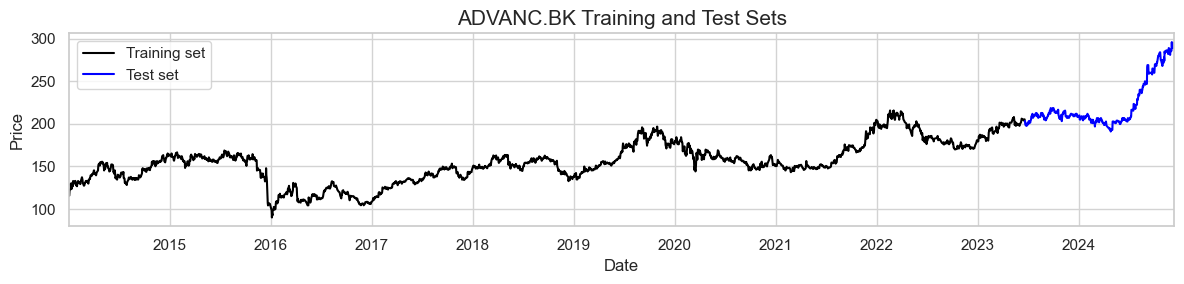

ADVANC.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
ADVANC.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: AOT.BK


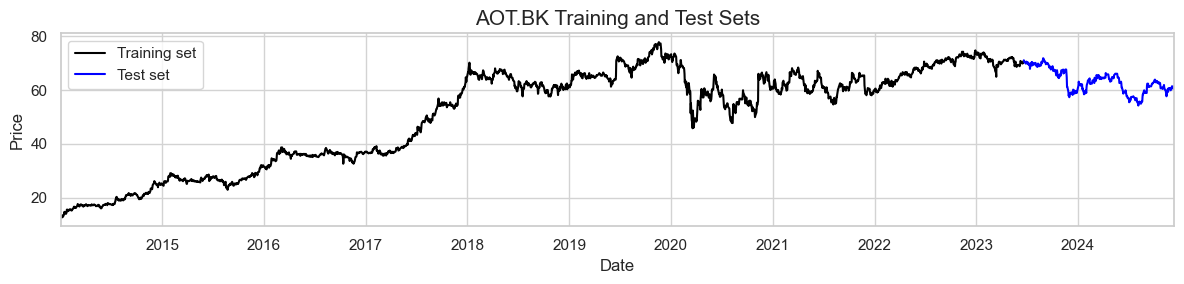

AOT.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
AOT.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: BBL.BK


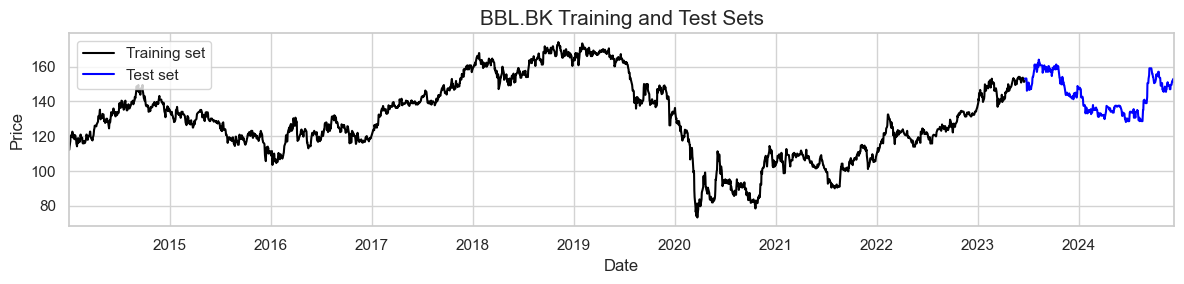

BBL.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
BBL.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: BDMS.BK


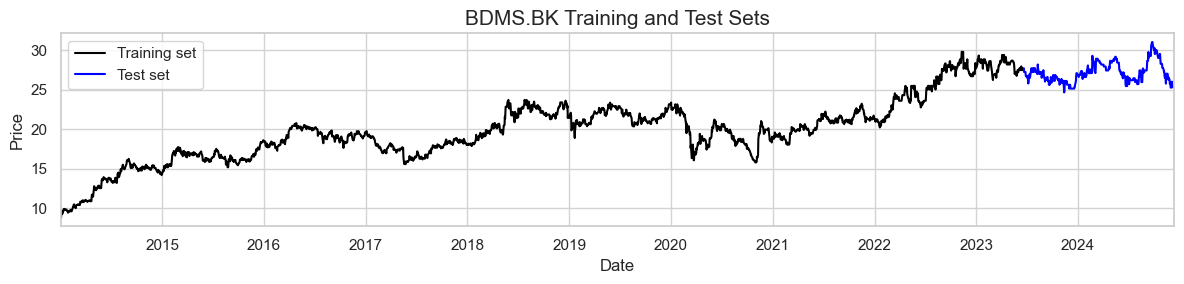

BDMS.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
BDMS.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: BH.BK


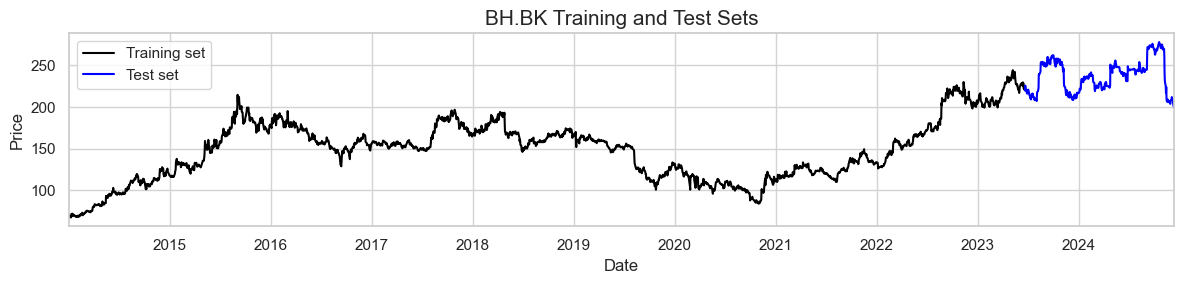

BH.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
BH.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: CPALL.BK


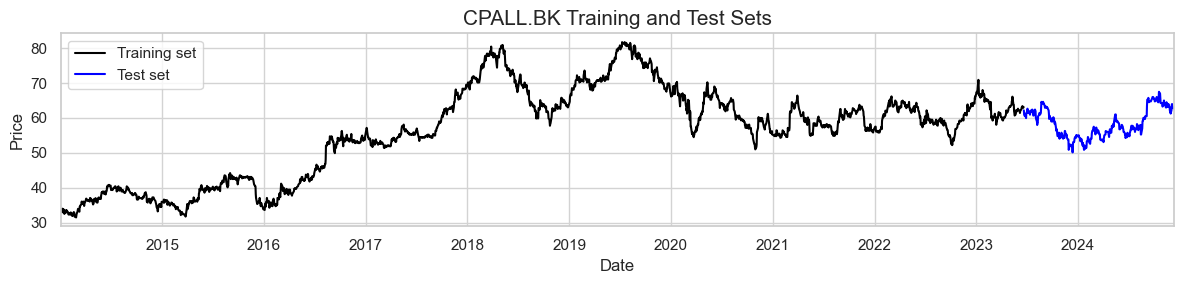

CPALL.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
CPALL.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: CPF.BK


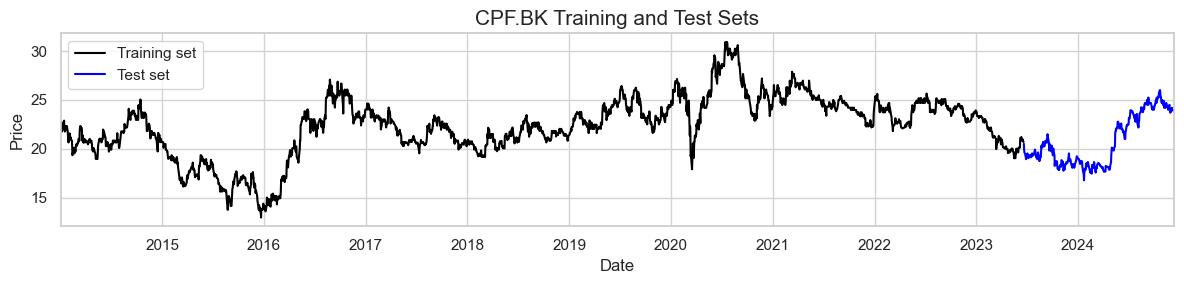

CPF.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
CPF.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: CPN.BK


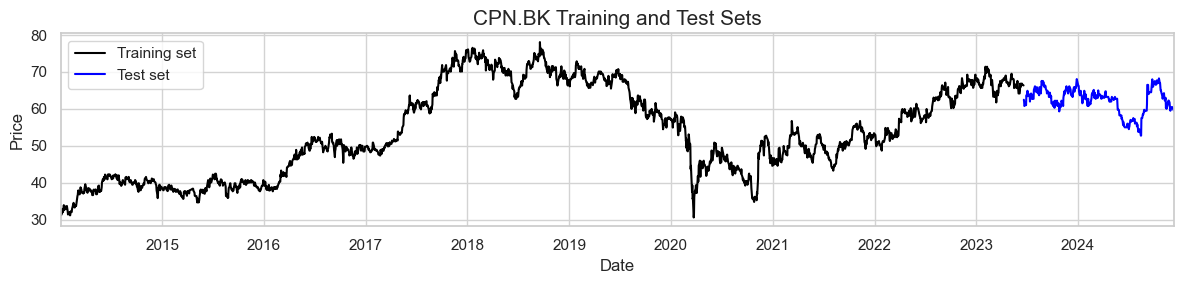

CPN.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
CPN.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: DELTA.BK


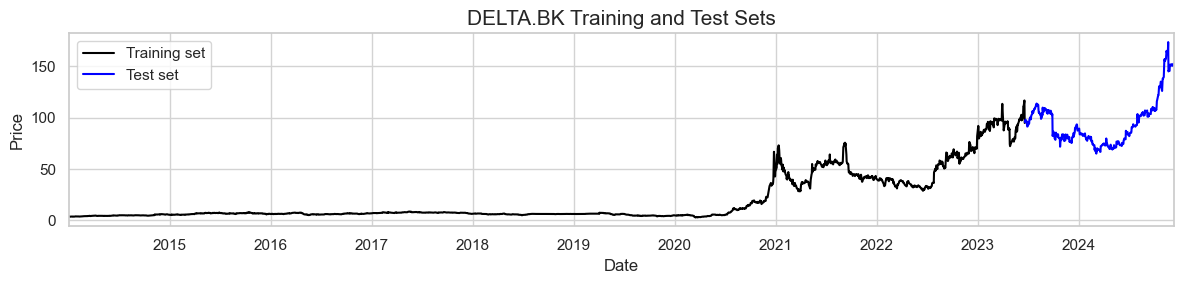

DELTA.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
DELTA.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: HMPRO.BK


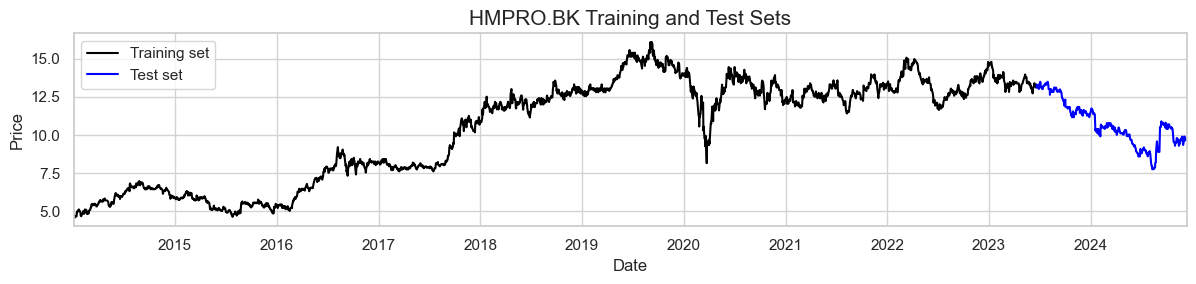

HMPRO.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
HMPRO.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: INTUCH.BK


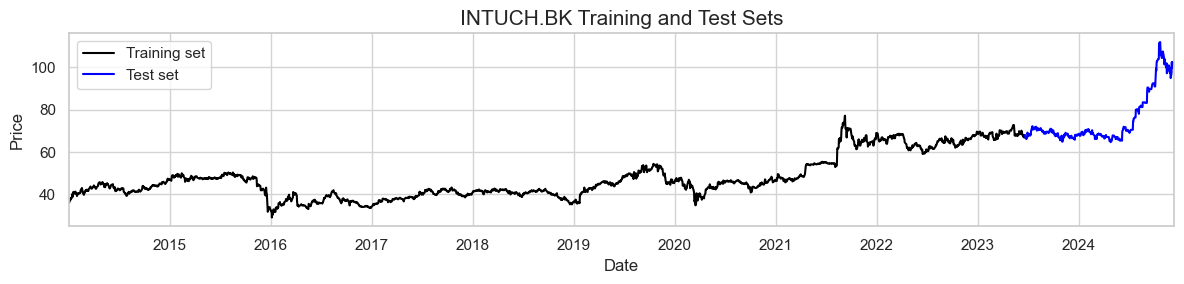

INTUCH.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
INTUCH.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: IVL.BK


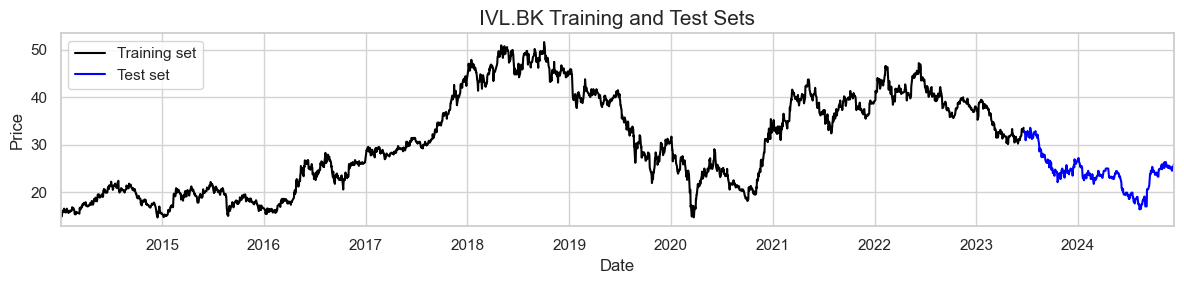

IVL.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
IVL.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: KBANK.BK


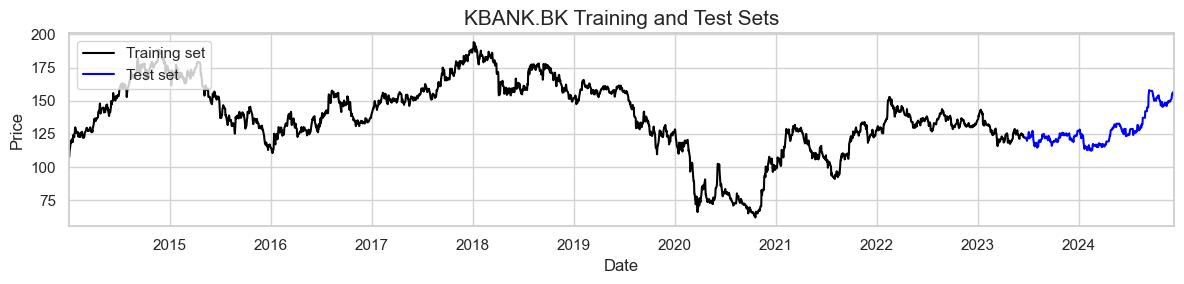

KBANK.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
KBANK.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: KTB.BK


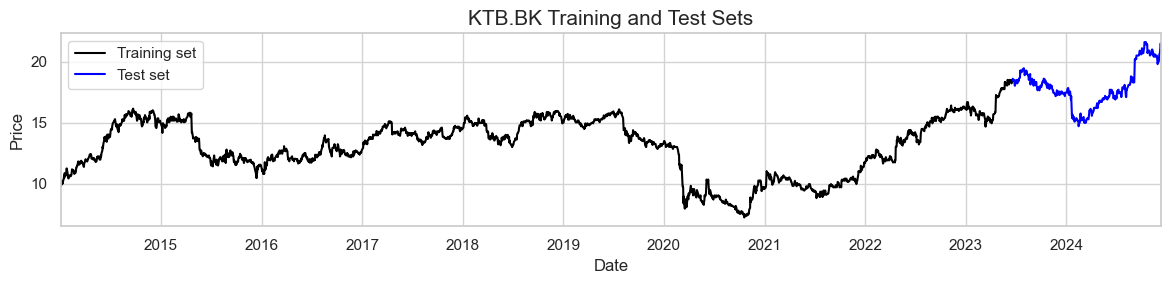

KTB.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
KTB.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: MINT.BK


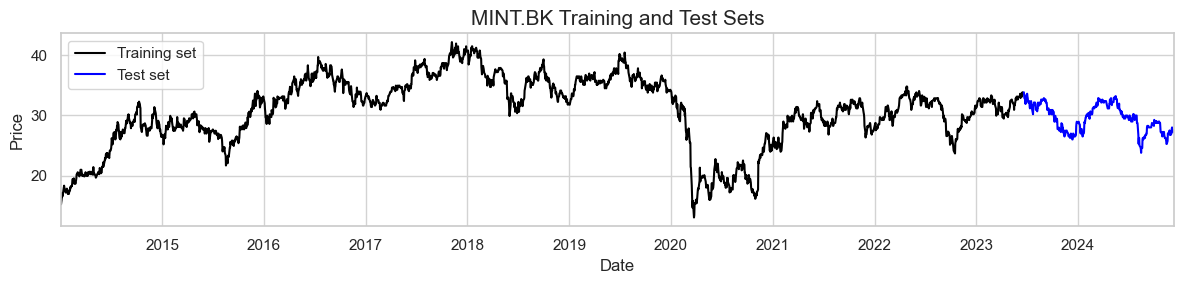

MINT.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
MINT.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: PTT.BK


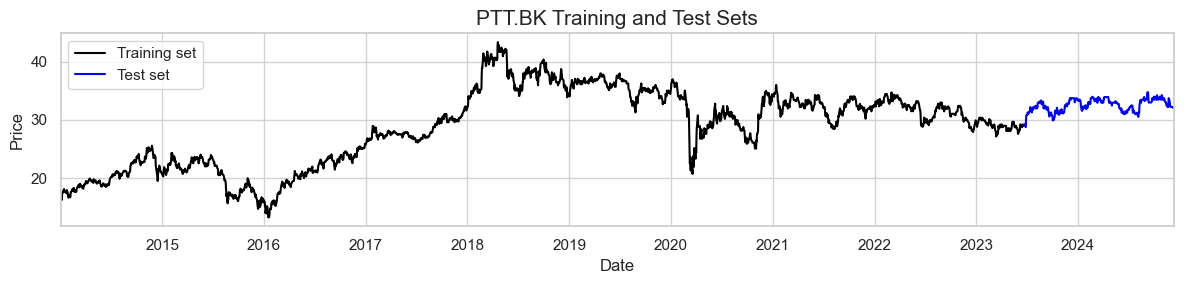

PTT.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
PTT.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: PTTEP.BK


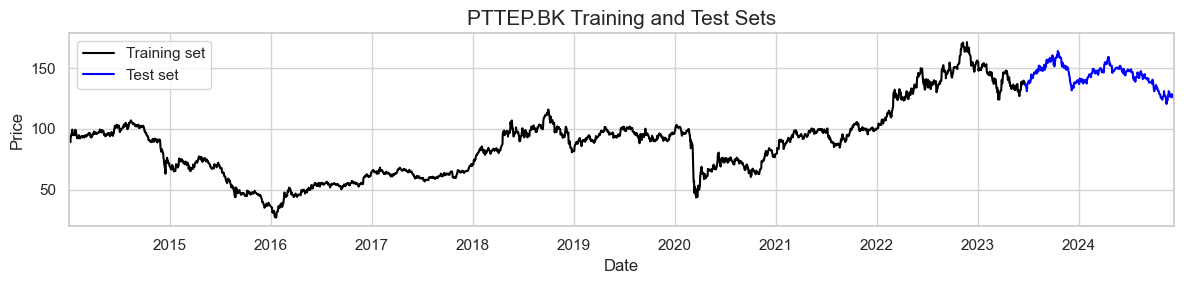

PTTEP.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
PTTEP.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: SCC.BK


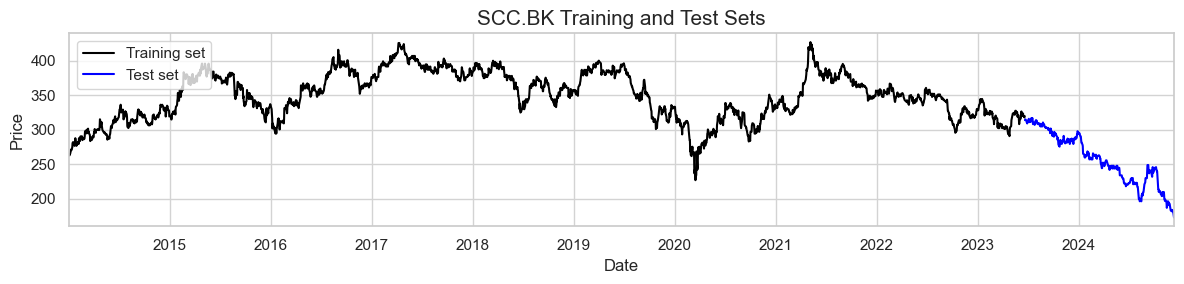

SCC.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
SCC.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: TRUE.BK


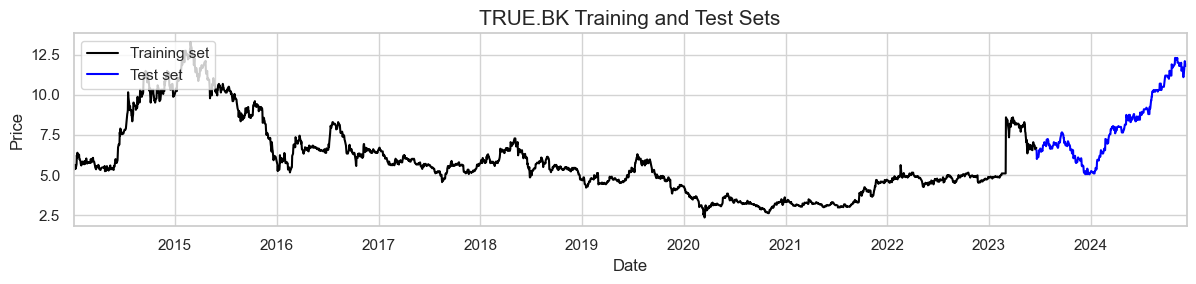

TRUE.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
TRUE.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: TTB.BK


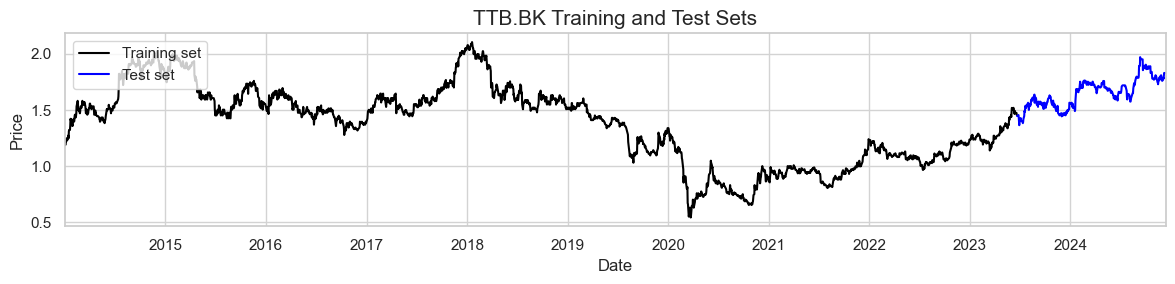

TTB.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
TTB.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)


In [152]:
# data preparation for dataframe set1
# Adjusting the portfolio for 1 year time frame 
results = data_prep(df=set1, stock_columns=stock_columns, test_size=test_size, window_size=window_size)

**Find the best hyperparameters**

In [222]:
# Function to Find the best hyperparameters
input1 = Input(shape=(window_size , 1))
def build_model(hp):
    # Tune the number of units in LSTM layers
    x = LSTM(units=hp.Int('units_layer_1', min_value=32, max_value=128, step=32), return_sequences=True)(input1)
    x = Dropout(hp.Float('dropout_layer_1', min_value=0.1, max_value=0.5, step=0.1))(x)

    x = LSTM(units=hp.Int('units_layer_2', min_value=32, max_value=128, step=32), return_sequences=True)(x)
    x = Dropout(hp.Float('dropout_layer_2', min_value=0.1, max_value=0.5, step=0.1))(x)

    x = LSTM(units=hp.Int('units_layer_3', min_value=32, max_value=128, step=32))(x)
    x = Dropout(hp.Float('dropout_layer_3', min_value=0.1, max_value=0.5, step=0.1))(x)

    x = Dense(hp.Int('dense_units', min_value=16, max_value=64, step=16), activation='relu')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])

    # Tune the optimizer and learning rate
    optimizer = hp.Choice('optimizer', values=['adam', 'nadam', 'rmsprop'])
    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer, 
                  metrics=['mean_squared_error'])
    return model

In [232]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Create the necessary directories if they don't exist
checkpoint_dir = 'tuner_results/lstm_tuning/'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Define the checkpoint path
checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint.weights.keras')

# Add ModelCheckpoint to save the model weights
model_checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')


In [238]:
# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error', 
    max_trials=1,  
    executions_per_trial=1,  
    directory='tuner_results',
    project_name='lstm_tuning'
)

Reloading Tuner from tuner_results/lstm_tuning/tuner0.json


In [240]:
# Loop through each column 
for stock in set1.columns:
    # Recall X_train, X_test, y_train, y_test for each stock
    X_train = results[stock]['X_train']
    X_test = results[stock]['X_test']
    y_train = results[stock]['y_train']
    y_test = results[stock]['y_test']
    
    # Now you can use these variables (X_train, X_test, y_train, y_test) for further processing
    print(f"Processed {stock}: X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

Processed ADVANC.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed AOT.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed BBL.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed BDMS.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed BH.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed CPALL.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed CPF.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed CPN.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed DELTA.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed HMPRO.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed INTUCH.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed IVL.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed KBANK.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed K

In [242]:
import time

# Start the timer for the entire process
t0 = time.time()

# Loop through each stock column in the dataframe
for stock in set1.columns:
    # Recall X_train, X_test, y_train, y_test for each stock
    X_train = results[stock]['X_train']
    X_test = results[stock]['X_test']
    y_train = results[stock]['y_train']
    y_test = results[stock]['y_test']
    
    # Hyperparameter tuning search for the current stock
    print(f"Starting tuning for {stock}...")
    tuner.search(X_train, y_train, 
                 epochs=50, 
                 batch_size=32, 
                 validation_split=0.2, 
                 verbose=1)
    
    # Get the best hyperparameters
    best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
    print(f"Best Hyperparameters for {stock}:\n {best_hyperparameters.values}")
    
    # Save the hyperparameters in a DataFrame
    hyperparameters_dict = best_hyperparameters.values
    hyperparameters_df = pd.DataFrame([hyperparameters_dict])
    hyperparameters_df.T  # Transpose for better display
    
    # Save the best model
    best_model = tuner.get_best_models(1)[0]
    print(f"\nEvaluating best model for {stock} on the test set...")
    test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
    print(f'Test accuracy for {stock}: {test_accuracy:.4f}')
    
    # Predictions (if needed)
    predictions = best_model.predict(X_test)

# Time to run in seconds for the entire process
print(f"Total time taken for the entire process: {time.time() - t0} seconds")


Starting tuning for ADVANC.BK...
Best Hyperparameters for ADVANC.BK:
 {'units_layer_1': 32, 'dropout_layer_1': 0.5, 'units_layer_2': 32, 'dropout_layer_2': 0.1, 'units_layer_3': 96, 'dropout_layer_3': 0.2, 'dense_units': 48, 'optimizer': 'rmsprop'}


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'tuner_results/lstm_tuning/trial_0/checkpoint.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

**Create function for LSTM model and Training**

**Evaluate the model**

**Investigating the prices predicted with actual**